# ROMY Processing - Prepare masked ZNE streams

Load ZUV data, process, mask with MLTI log and store as masked streams

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy.ma as ma

from numpy import where
from andbro__read_sds import __read_sds

from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE
from functions.load_lxx import __load_lxx
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
def __write_stream_to_sds(st, cha, path_to_sds):

    import os

    # check if output path exists
    if not os.path.exists(path_to_sds):
        print(f" -> {path_to_sds} does not exist!")
        return

    tr = st.select(channel=cha)[0]

    nn, ss, ll, cc = tr.stats.network, tr.stats.station, tr.stats.location, tr.stats.channel
    yy, jj = tr.stats.starttime.year, str(tr.stats.starttime.julday).rjust(3,"0")

    if not os.path.exists(path_to_sds+f"{yy}/"):
        os.mkdir(path_to_sds+f"{yy}/")
        print(f"creating: {path_to_sds}{yy}/")
    if not os.path.exists(path_to_sds+f"{yy}/{nn}/"):
        os.mkdir(path_to_sds+f"{yy}/{nn}/")
        print(f"creating: {path_to_sds}{yy}/{nn}/")
    if not os.path.exists(path_to_sds+f"{yy}/{nn}/{ss}/"):
        os.mkdir(path_to_sds+f"{yy}/{nn}/{ss}/")
        print(f"creating: {path_to_sds}{yy}/{nn}/{ss}/")
    if not os.path.exists(path_to_sds+f"{yy}/{nn}/{ss}/{cc}.D"):
        os.mkdir(path_to_sds+f"{yy}/{nn}/{ss}/{cc}.D")
        print(f"creating: {path_to_sds}{yy}/{nn}/{ss}/{cc}.D")

    st.write(path_to_sds+f"{yy}/{nn}/{ss}/{cc}.D/"+f"{nn}.{ss}.{ll}.{cc}.D.{yy}.{jj}", format="MSEED")

    print(f" -> stored stream as: {yy}/{nn}/{ss}/{cc}.D/{nn}.{ss}.{ll}.{cc}.D.{yy}.{jj}")

In [4]:
def __mlti_intervals_to_zero(dat, times, mlti_t1, mlti_t2, t_offset_sec=120):

    from numpy import nan, where, full, array

    dat = array(dat)

    mask = full((len(times)), 0, dtype=int)

    idx = 0
    for nn, tt in enumerate(times):

        if idx >= len(mlti_t1):
            continue
        else:
            t1, t2 = (mlti_t1[idx]-t_offset_sec), (mlti_t2[idx]+t_offset_sec)

        if tt >= t1:
            mask[nn] = 1
        if tt > t2:
            idx += 1

    dat = where(mask == 1, 1, dat)

    return dat

In [5]:
def __get_trace(seed):

    from numpy import zeros

    net, sta, loc, cha = seed.split('.')

    trr = obs.Trace()
    trr.stats.starttime = config['t1']
    trr.data = zeros(config['Nexpected'])
    trr.stats.network = net
    trr.stats.station = sta
    trr.stats.location = loc
    trr.stats.channel = cha
    trr.stats.sampling_rate = config['sampling_rate']

    return trr

## Configurations

In [20]:
config = {}

config['path_to_sds'] = archive_path+"romy_archive/"

config['path_to_sds_out'] = archive_path+"temp_archive/"

config['path_to_inventory'] = root_path+"Documents/ROMY/stationxml_ringlaser/dataless/"

config['tbeg'] = obs.UTCDateTime("2024-06-04")
config['tend'] = config['tbeg'] + 7200

config['sampling_rate'] = 20 # Hz

config['time_offset'] = 60 # seconds

config['t1'] = config['tbeg']-config['time_offset']
config['t2'] = config['tend']+config['time_offset']

config['Nexpected'] = int((config['t2'] - config['t1']) * config['sampling_rate'])


## Load Data

In [21]:
# load MLTI logs
mltiU = __load_mlti(config['t1'], config['t2'], "U", archive_path)
mltiV = __load_mlti(config['t1'], config['t2'], "V", archive_path)
mltiZ = __load_mlti(config['t1'], config['t2'], "Z", archive_path)

# load maintenance file
lxx = __load_lxx(config['t1'], config['t2'], archive_path)


#### Load inventory

In [22]:
romy_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")

In [23]:
st0 = obs.Stream()

st0 += __read_sds(config['path_to_sds'], "BW.ROMY.10.BJZ", config['t1'], config['t2'])
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJU", config['t1'], config['t2'])
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJV", config['t1'], config['t2'])

# remove sensitivity
st0 = st0.remove_sensitivity(romy_inv)

print(st0)

# check if merging is required
if len(st0) > 3:
    print(f" -> merging required!")
    st0.merge(fill_value="interpolate")

print(st0)

# remove trend
st0 = st0.detrend("linear")

# check if data has same length
for tr in st0:
    Nreal = len(tr.data)
    if Nreal != config['Nexpected']:
        tr.data = tr.data[:config['Nexpected']]
        # print(f" -> adjust length: {tr.stats.station}.{tr.stats.channel}:  {Nreal} -> {config['Nexpected']}")

st0 = __rotate_romy_ZUV_ZNE(st0, romy_inv, keep_z=True)

# st0 = st0.trim(config['tbeg'], config['tend'])

st0

3 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2024-06-03T23:59:00.009800Z - 2024-06-04T02:01:00.009800Z | 20.0 Hz, 146401 samples
BW.ROMY..BJU   | 2024-06-03T23:59:00.009600Z - 2024-06-04T02:01:00.009600Z | 20.0 Hz, 146401 samples
BW.ROMY..BJV   | 2024-06-03T23:58:59.994200Z - 2024-06-04T02:00:59.994200Z | 20.0 Hz, 146401 samples
3 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2024-06-03T23:59:00.009800Z - 2024-06-04T02:01:00.009800Z | 20.0 Hz, 146401 samples
BW.ROMY..BJU   | 2024-06-03T23:59:00.009600Z - 2024-06-04T02:01:00.009600Z | 20.0 Hz, 146401 samples
BW.ROMY..BJV   | 2024-06-03T23:58:59.994200Z - 2024-06-04T02:00:59.994200Z | 20.0 Hz, 146401 samples


3 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2024-06-03T23:59:00.009800Z - 2024-06-04T02:00:59.959800Z | 20.0 Hz, 146400 samples
BW.ROMY..BJN   | 2024-06-03T23:59:00.009600Z - 2024-06-04T02:00:59.959600Z | 20.0 Hz, 146400 samples
BW.ROMY..BJE   | 2024-06-03T23:58:59.994200Z - 2024-06-04T02:00:59.944200Z | 20.0 Hz, 146400 samples

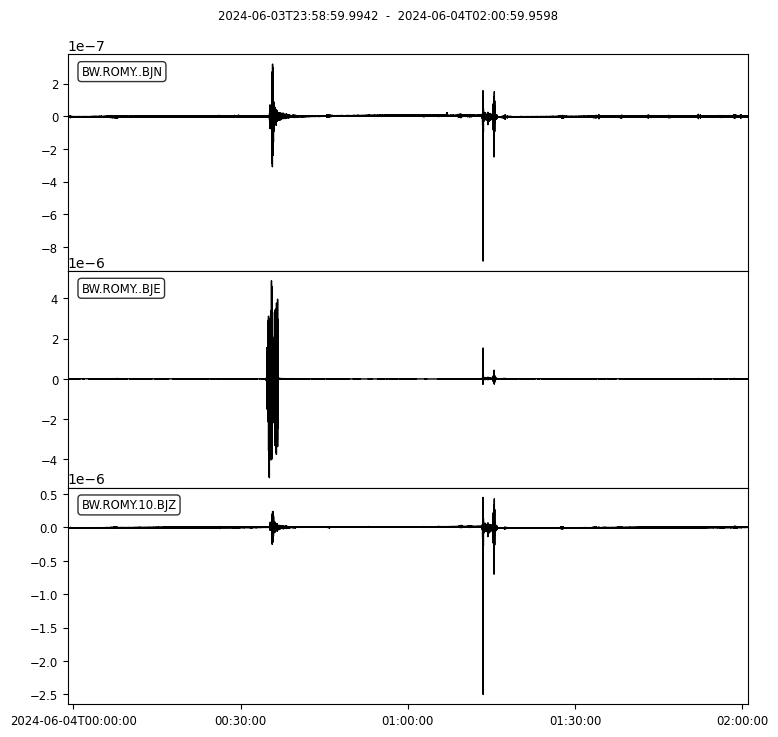

In [24]:
st0.plot(equal_scale=False);

In [25]:
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)
mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)
mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

In [26]:
tr_mltiU = __get_trace("BW.ROMY.30.MLT")

tr_mltiU.data = __mlti_intervals_to_zero(tr_mltiU.data,
                                         tr_mltiU.times(reftime=config['t1'], type="utcdatetime"),
                                         mltiU_t1,
                                         mltiU_t2,
                                         t_offset_sec=120
                                         )

In [27]:
tr_mltiV = __get_trace("BW.ROMY.30.MLT")

tr_mltiV.data = __mlti_intervals_to_zero(tr_mltiV.data,
                                         tr_mltiV.times(reftime=config['t1'], type="utcdatetime"),
                                         mltiV_t1,
                                         mltiV_t2,
                                         t_offset_sec=120
                                         )

In [28]:
tr_mltiZ = __get_trace("BW.ROMY.30.MLT")

tr_mltiZ.data = __mlti_intervals_to_zero(tr_mltiZ.data,
                                         tr_mltiZ.times(reftime=config['t1'], type="utcdatetime"),
                                         mltiZ_t1,
                                         mltiZ_t2,
                                         t_offset_sec=120
                                         )

In [29]:
lxx_t1, lxx_t2 = __get_mlti_intervals(lxx.datetime)

In [30]:
tr_lxx = __get_trace("BW.ROMY.30.LXX")

tr_lxx.data = __mlti_intervals_to_zero(tr_lxx.data,
                                       tr_lxx.times(reftime=config['t1'], type="utcdatetime"),
                                       lxx_t1,
                                       lxx_t2,
                                       t_offset_sec=60
                                       )

In [31]:
# make mlti trace for horizontals (since rotated and intermixed)
tr_mltiH = tr_mltiU.copy()

# combine mlti periods
tr_mltiH.data = tr_mltiU.data + tr_mltiV.data

# remove periods with value 2 due to summation
tr_mltiH.data = where(tr_mltiH.data > 1, 1, tr_mltiH.data)

In [18]:
from functions.get_phase_jumps import __get_phase_jumps

-9.824075312166665e-06 9.740832876628295e-06


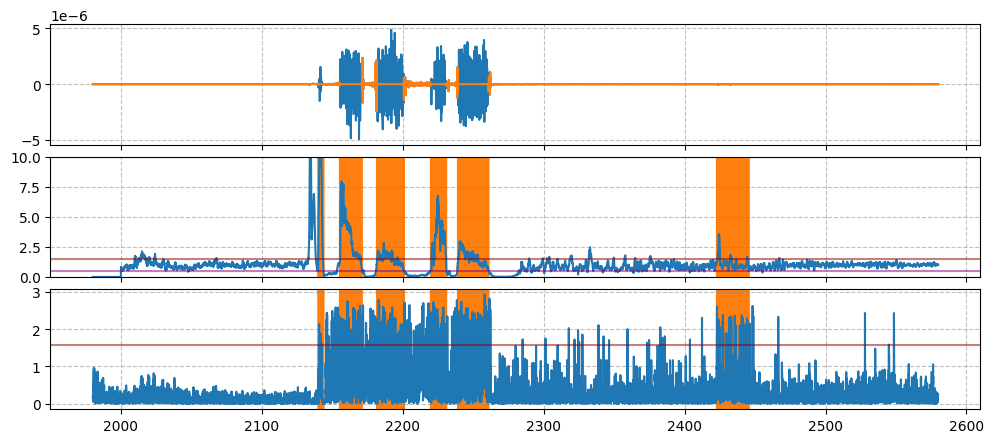

In [356]:
def get_phase_jumps(arr, times, LT, ST, amp_threshold, plot=True):

    from scipy.signal import hilbert

    pha_threshold = np.pi/2

    amp_threshold_lower = 0.5

    _data = arr.copy()

    # remove mean of data to avoid jumps at start and end
    _data -= np.nanmean(_data)

    # avoid having to deal with nan values
    _data = np.nan_to_num(_data, nan=0)

    # compute Hilbert transform
    H = hilbert(_data)

    # obtain angle of hilibert
    # pha = np.angle(H)
    pha = np.unwrap(np.angle(H))

    # derivative of angle
    dpha = np.gradient(pha, edge_order=1)

    dpha = abs(dpha)

    from functions.smoothing import __smooth
    dpha = __smooth(dpha, 3)

    N = len(_data)

    detect = np.ones(N)
    amp_ratio = np.zeros(N)
    pha_ratio = np.zeros(N)

    triggered = False
    for n in range(N):

        if n < LT:
            continue

        LTA = np.nanmean(abs(arr[n-int(LT):n]))
        STA = np.nanmean(abs(arr[n-int(ST):n]))

        amp_ratio[n] = STA/LTA

        LTP = np.nanmean(abs(dpha[n-int(100):n]))
        STP = np.nanmean(abs(dpha[n-int(2):n]))

        pha_ratio[n] = STP/LTP

        if triggered and amp_ratio[n] > amp_threshold_lower:
            detect[n] = 0
            continue
        else:
            triggered = False

        if amp_ratio[n] > amp_threshold and dpha[n] > pha_threshold:
            detect[n] = 0
            detect[n-10:n] = 0
            triggered = True

    if plot:

        import matplotlib.pyplot as plt

        Nrow, Ncol = 3, 1

        font = 12

        fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        ax[0].plot(times, arr)
        ax[0].plot(times, arr*np.array(detect))

        ax[1].plot(times, amp_ratio)
        ax[1].axhline(amp_threshold, color="darkred", alpha=0.5)
        ax[1].axhline(amp_threshold_lower, color="purple", alpha=0.5)
        ax[1].set_ylim(0, 10)
        # ax[1].set_yscale("log")

        ax[2].plot(times, dpha)
        ax[2].axhline(pha_threshold, color="darkred", alpha=0.5)

        for _k in range(Nrow):
            ax[_k].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

        print(np.nanmin(arr)*2, np.nanmax(arr)*2)
        for _n, d in enumerate(detect):
            if d == 0:
                ax[0].axvline(times[_n], np.nanmin(arr)*2, np.nanmax(arr)*2, color="tab:orange", alpha=0.4, zorder=1)
                ax[1].axvline(times[_n], 0, max(amp_ratio)*2, color="tab:orange", alpha=0.4, zorder=1)
                ax[2].axvline(times[_n], 0, max(amp_ratio)*2, color="tab:orange", alpha=0.4, zorder=1)

        plt.show();

    return np.array(pha_ratio), np.array(detect)

z = st0.select(component="E")[0]

x1 = int(0.55*3600*20)
x2 = x1+600*20

data0 = z.data[x1:x2]
time = z.times()[x1:x2]

ratio, detect = get_phase_jumps(data0, time, 400, 20, amp_threshold=1.5)

(-4.912037656083333e-06, 4.870416438314147e-06)

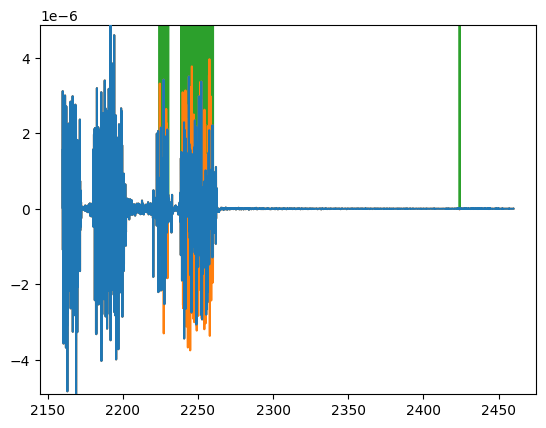

In [282]:
import numpy as np

data_mod = data0 * detect

plt.plot(time, data_mod, zorder=3)
plt.plot(time, data0, zorder=2)
plt.plot(time, detect, zorder=1)

plt.ylim(min(data0), max(data0))

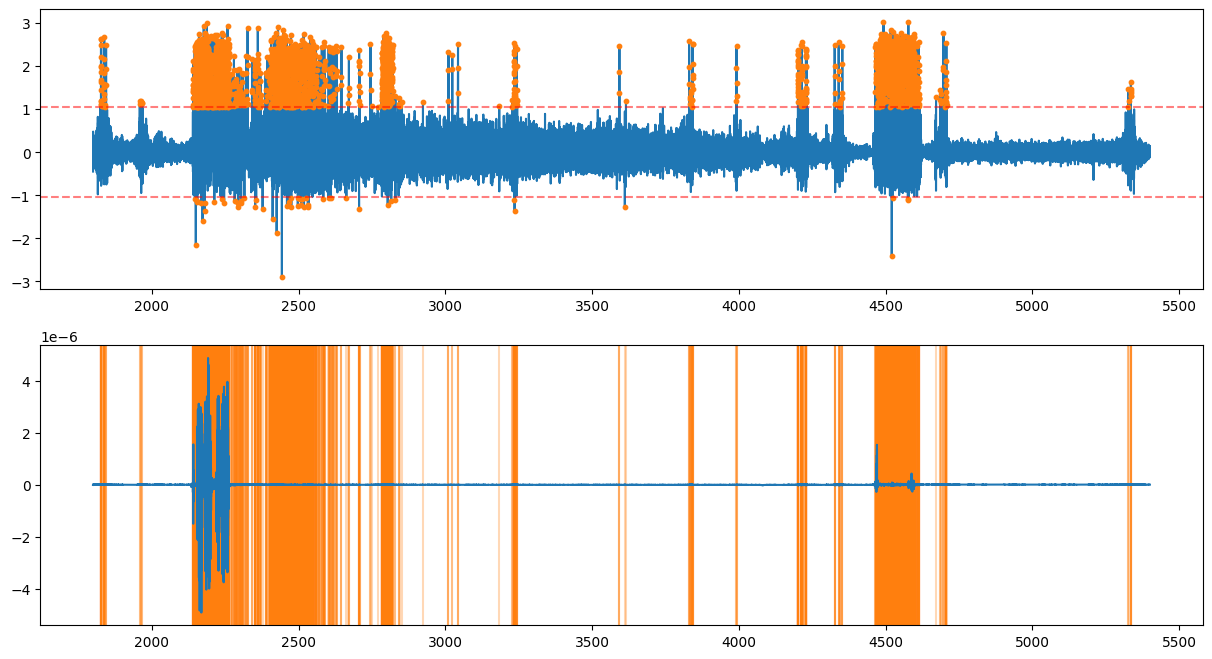

(array([-1.76085457e-09,  4.74234081e-09, -3.72767302e-09, ...,
         3.61699704e-09,  4.00099008e-09,  3.47463303e-09]),
 array([1825.85, 1826.5 , 1826.65, ..., 5334.7 , 5334.95, 5335.2 ]),
 array([1.09234707, 1.1296948 , 1.18100861, ..., 1.30751302, 1.38158913,
        1.6447388 ]),
 array([  517,   530,   533, ..., 70694, 70699, 70704]))

In [172]:
x1 = int(0.5*3600*20)
x2 = x1+3600*20

__get_phase_jumps(z.data[x1:x2], z.times()[x1:x2], fraction_of_pi=3, plot=True)

In [150]:
import numpy as np

def despike(pixel, doys, thresh = 0.05, nodata = 0):
    """
    Iteratively despike a timeseries using linear interpolation and taking the upper envelope.

    Parameters
    ----------
    pixel : array
        The Timeseries' y-values
    doys : array
        Day of year, ie The timeseries' x-values
    thresh : float
        The despiking threshold. Spikes are defined as points on the timeseries
        which differ from their interpolation by more than this value.
    nodata : float
        NoData value, will be removed from timeseries
   Returns
   -------
   pixel2 : array
       Updated and despiked timeseries y-values
   Doys2 : array
       Updated timeseries x-values (nodata and NaN values removed)
    """

    valid_inds = np.where((pixel != nodata) & np.isfinite(pixel))  # find valid indices (not NaN not nodata)
    doys2 = doys[valid_inds]  # remove invalid data
    pixel2 = pixel[valid_inds]  # remove invalid data
    iterations = 20
    max_dif = 100

    while max_dif > thresh and iterations < 100:
        # create left and right verisons of arrays:
        y1 = np.roll(pixel2, -1)
        y2 = np.roll(pixel2, 1)
        x1 = np.roll(doys2, -1)
        x2 = np.roll(doys2, 1)
        x1[0], y1[0], x2[-1], y2[-1] = doys2[0], pixel2[0], doys2[-1], pixel2[-1]  # handle edges
        interp = ((y2-y1)/(x2-x1))*(doys2 - x1)+y1  # caluculate neighbour interpolation for each point        
        interp[0], interp[-1] = np.mean(pixel2[1:3]), np.mean(pixel2[-3:-1])  # set edges of interpolation as mean of closest 2 points
        diff = interp - pixel2   # difference between value and interpolation
        max_dif = np.max(diff)
        # remove spike if over thresh:
        if max_dif > thresh:
            bigspike = np.argmax(diff)
            pixel2[bigspike] = interp[bigspike]
        iterations +=1
    return pixel2, doys2



In [142]:
st0

3 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2024-06-03T23:59:00.009800Z - 2024-06-04T02:00:59.959800Z | 20.0 Hz, 146400 samples
BW.ROMY..BJN   | 2024-06-03T23:59:00.009600Z - 2024-06-04T02:00:59.959600Z | 20.0 Hz, 146400 samples
BW.ROMY..BJE   | 2024-06-03T23:58:59.994200Z - 2024-06-04T02:00:59.944200Z | 20.0 Hz, 146400 samples

In [143]:
x1 = int(0.58*3600*20)
x2 = x1+300*20

data = st0.select(component="E")[0].data[x1:x2]
time = st0.select(component="E")[0].times()[x1:x2]

In [144]:
y, x = despike(data, time, thresh=1e-7, nodata=np.nan)

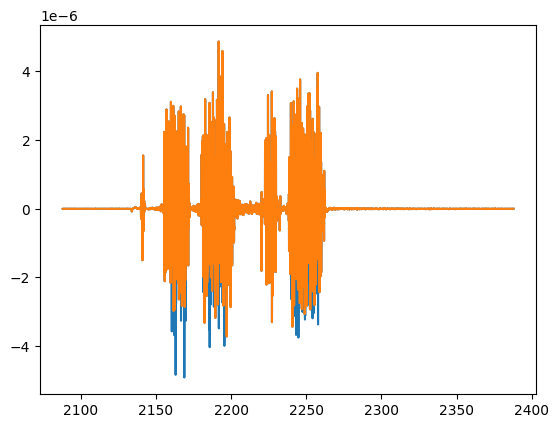

In [145]:
plt.plot(time, data)
plt.plot(x, y)

## Write Data

In [18]:
outZ = obs.Stream()

outZ += st0.select(component="Z").copy()
outZ.select(component="Z")[0].stats.location = "30"
outZ += tr_mltiZ.copy()
outZ += tr_lxx.copy()

outZ = outZ.trim(config['tbeg'], config['tend'], nearest_sample=False)

# __write_stream_to_sds(outZ, "BJZ", config['path_to_sds_out'])


In [19]:
outN = obs.Stream()

outN += st0.select(component="N").copy()
outN.select(component="N")[0].stats.location = "30"
outN += tr_mltiH.copy()
outN += tr_lxx.copy()

outN = outN.trim(config['tbeg'], config['tend'], nearest_sample=False)

# __write_stream_to_sds(outN, "BJN", config['path_to_sds_out'])


In [20]:
outE = obs.Stream()

outE += st0.select(component="E").copy()
outE.select(component="E")[0].stats.location = "30"
outE += tr_mltiH.copy()
outE += tr_lxx.copy()

outE = outE.trim(config['tbeg'], config['tend'], nearest_sample=False)

# __write_stream_to_sds(outE, "BJE", config['path_to_sds_out'])


## Option 2

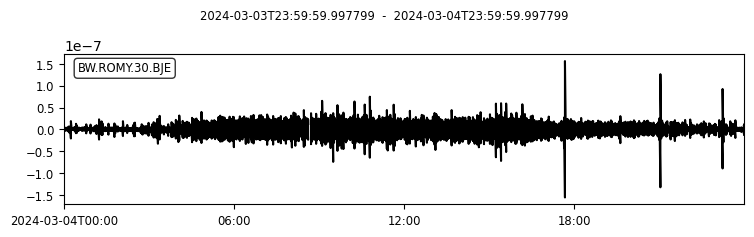

In [38]:
outZ = obs.Stream()

outZ += st0.select(component="Z").copy()
outZ.select(component="Z")[0].stats.location = "30"

data = outZ.select(component="Z")[0].data
mask = tr_mltiZ.data

if len(data) != len(mask):
    mask = mask[:len(data)]
outZ.select(component="Z")[0].data = ma.masked_array(data,
                                                     mask=mask,
                                                     )

outZ = outZ.trim(config['tbeg'], config['tend'])

outZ = outZ.split()

# __write_stream_to_sds(outN, "BJZ", config['path_to_sds_out'])

outE.plot();

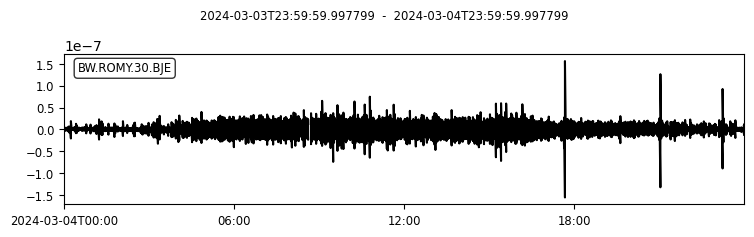

In [39]:
outE = obs.Stream()

outE += st0.select(component="E").copy()
outE.select(component="E")[0].stats.location = "30"

data = outE.select(component="E")[0].data
mask = tr_mltiH.data

if len(data) != len(mask):
    mask = mask[:len(data)]
outE.select(component="E")[0].data = ma.masked_array(data,
                                                     mask=mask,
                                                     )

outE = outE.trim(config['tbeg'], config['tend'])

outE = outE.split()

# __write_stream_to_sds(outN, "BJE", config['path_to_sds_out'])

outE.plot();

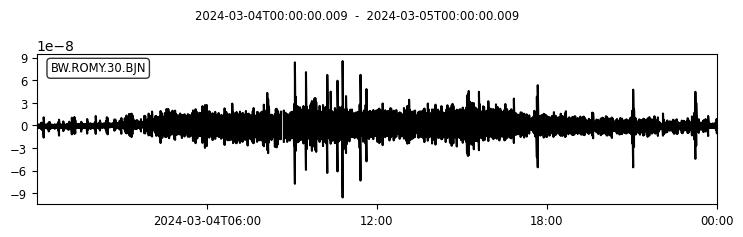

In [40]:
outN = obs.Stream()

outN += st0.select(component="N").copy()
outN.select(component="N")[0].stats.location = "30"

data = outN.select(component="N")[0].data
mask = tr_mltiH.data

if len(data) != len(mask):
    mask = mask[:len(data)]
outN.select(component="N")[0].data = ma.masked_array(data,
                                                     mask=mask,
                                                     )

outN = outN.trim(config['tbeg'], config['tend'])

outN = outN.split()

# __write_stream_to_sds(outN, "BJN", config['path_to_sds_out'])

outN.plot();